# How to compute LSD profiles

In this tutorial, we demonstrate the calculation of LSD profiles using the <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy`</a> function, which is a wrapper around the main function of the [LSDpy](https://github.com/folsomcp/LSDpy) Package. 

The advantage of the <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy`</a> function is that it has been designed with default options that made it easy to use in interactive shells and within python scripts. 

:::{warning}
You can of course use the LSDpy.lsd() function directly -- however it has different input requirements.  It requires all parameters to be passed explicitly or it will fallback to reading missing parameters from an input file `inlsd.dat`.  This is more well suited for a command-line workflow, see [](../GetStarted/Quickstart_CLI.md) for details.
:::

We need to import specpolFlow.

In [1]:
import specpolFlow as pol
import matplotlib.pyplot as plt

In this tutorial, we assume that you already have a normalized spectrum in a .s format, and a mask file that has been suitably cleaned for your needs. 

We will use these two files [hd46328_test_1.s.norm](https://github.com/folsomcp/specpolFlow/blob/main/docs-jb/Tutorials/HoToLSD_tutorialfiles/hd46328_test_1.s.norm) and [hd46328_test_depth0.02_clean.mask](https://github.com/folsomcp/specpolFlow/blob/main/docs-jb/Tutorials/HowToLSD_tutorialfiles/hd46328_test_depth0.02_clean.mask)

:::{admonition} No normalized .s file?
:class: tip, dropdown
See the following tutorials
* [](./1-ConvertToSFiles_Tutorial.ipynb)
* [](../GetStarted/NormalizingOneSpectrum.md)
* [](./2-Normalizing_Tutorial.md)
:::

:::{admonition} No mask file?
:class: tip, dropdown
See the walkthrough in [](../GetStarted/OneObservationFlow_Tutorial.ipynb),
and also the following tutorials
* [](./3-MaskClass_Tutorial.ipynb)
* [](./3b-MaskUI_Tutorial.md)
* [](./4-ExcludeMaskRegionClass_Tutorial.ipynb)
:::

In the cell below, we set some variables with the path/name of the observation file and the mask file.

In [2]:
mask_file = 'HowToLSD_tutorialfiles/hd46328_test_depth0.02_clean.mask'
obs_file  = 'HowToLSD_tutorialfiles/hd46328_test_1.s.norm'

## 1. Calculating an LSD profile "on-the-fly"

First, we demonstrate a very simple application of the <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy`</a> function.

:::{note}
The <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy`</a> function returns 2 Python objects:
* An <a href='../API/LSD_API.html#specpolFlow.LSD'>`LSD`</a> with the computed LSD profile
* A <a href='../API/Spectrum_API.html#specpolFlow.Spectrum'>`Spectrum`</a> object with the LSD model spectrum (more on this later)

In the example below, we have unpacked the returned tuple into two separate variables. 
:::

Modified line mask, removed 64 too closely spaced lines
Average observed spec velocity spacing: 1.810029 km/s
using a 222 point profile with 1.810000 km/s pixels
mean mask depth 0.101386 wl 494.081 Lande 1.179956 (from 1039 lines)
mean mask norm weightI 0.506930 weightV 0.480710
saving model spectrum to  ...
I reduced chi2 193.8252 (chi2 19858356.38 constraints 102677 dof 222)
 Rescaling error bars by: 13.922110
V reduced chi2 1.1163 (chi2 114372.85 constraints 102677 dof 222)
 Rescaling error bars by: 1.056562
 removing profile continuum pol: -5.3633e-06 +/- 1.2232e-08 (avg err 1.1045e-04)
N1 reduced chi2 1.1078 (chi2 113495.43 constraints 102677 dof 222)
 Rescaling error bars by: 1.052501
 removing profile continuum pol: -6.5530e-06 +/- 1.2138e-08 (avg err 1.1003e-04)
line range estimate -20.809999999999775 49.780000000000314 km/s
V in line reduced chi^2 51.897682 (chi2 2024.009582) 
 detect prob 1.000000 (fap 0.000000e+00)
 Detection! V (fap 0.000000e+00)
 V outside line reduced chi

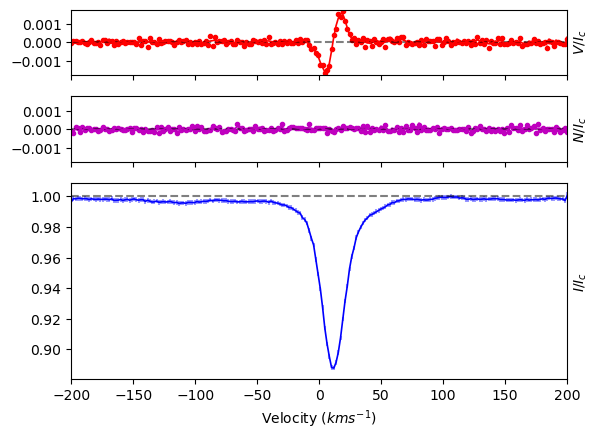

In [3]:
lsd, mod = pol.run_lsdpy(obs=obs_file, mask=mask_file)

The <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy`</a> function outputs some information about the calculation. For example, it provides 
* the average line parameters (simple average, not SNR-weighted average),
* the scaling that was used for the error bars based on the quality of the LSD model spectrum (see the next section),
* an initial computation of the False Alarm Probability (FAP) and of the longitudinal magnetic field.
    :::{warning}
    This automated calculation might work all right for well-behaved line profiles, but we strongly recommend that you perform a more thorough computation. See:
    - [](../GetStarted/OneObservationFlow_Tutorial.ipynb)
    - [](./6-CalculateBz_Tutorial.ipynb)
    :::

There is also a plot generated. If you would like to turn off the plot, simply set `plotLSD=False`

### 1.1 Setting the velocity limits/grid and the LSD weights

In this section, we discuss some often-used options to the <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy`</a> function. 

The velocity grid that is used to compute the LSD profile is controlled by the `velStart`, `velEnd`, and the `velPixel` keywords. 

In the example above, there is a lot of continuum on each side of the profile, and we could restrict the range of velocity to, say, -100 to 100 km/s. 

The default velocity step in <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy`</a> is estimated from the median pixel spacing in the observation.  For ESPaDOnS spectra this is 1.8 km/s. Because the spectral line is a bit broad, we could increase this a bit to, say, 3.6 km/s and have at roughly 15 datapoints inside of the spectral line. 

It's usually a good practice to set `velPixel` explicitly.  Usually this should be set to the typical pixel size of the observation.  If the lines are broad and the S/N is insufficient you could try to set the `velPixel` to a larger value, usually a multiple of the observation's pixel size.  Using a larger value effectively coadds pixels in the LSD process, trading resolution for higher S/N per pixel.  Generally you should not set `velPixel` smaller than the observed pixel size. Making `velPixel` too small will over-sample the observation, causing artifacts in the LSD profile that look high frequency noise (clusters of single pixel spikes).

In [4]:
lsd2, mod2 = pol.run_lsdpy(obs=obs_file, mask=mask_file, 
                         velStart=-100.0, velEnd=100.0, velPixel=3.6, 
                         plotLSD=False)

Modified line mask, removed 89 too closely spaced lines
Average observed spec velocity spacing: 1.810029 km/s
using a 57 point profile with 3.600000 km/s pixels
mean mask depth 0.103886 wl 494.567 Lande 1.181334 (from 1014 lines)
mean mask norm weightI 0.519428 weightV 0.491975
saving model spectrum to  ...
I reduced chi2 217.9563 (chi2 17029364.62 constraints 78189 dof 57)
 Rescaling error bars by: 14.763344
V reduced chi2 1.1255 (chi2 87938.82 constraints 78189 dof 57)
 Rescaling error bars by: 1.060903
 removing profile continuum pol: -6.7497e-06 +/- 6.2336e-09 (avg err 7.8699e-05)
N1 reduced chi2 1.1033 (chi2 86201.79 constraints 78189 dof 57)
 Rescaling error bars by: 1.050373
 removing profile continuum pol: -1.2885e-06 +/- 6.1105e-09 (avg err 7.7918e-05)
(possible Stokes I uncertainty underestimate 7.6549e-03 vs 1.1378e-03)
line range estimate -2.8000000000001535 25.9999999999998 km/s
V in line reduced chi^2 259.094143 (chi2 2072.753145) 
 detect prob 1.000000 (fap 0.000000e+00)

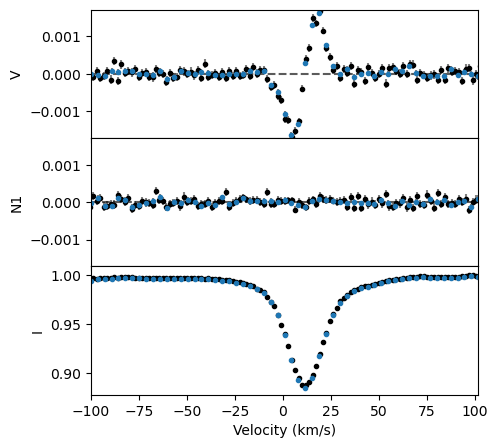

In [5]:
fig, ax = lsd.plot(figsize=(5,5))
fig, ax = lsd2.plot(fig=fig)

Another often neglected parameter that is essential to the LSD computation is the normalization weights. 

The intensity (Stokes I) line weight is proportional to the line depth ($d$). The polarization weight (Stokes V) is proportional to $d \times g \times \lambda$, where $g$ is the Landé factor and $\lambda$ is the wavelength of the line. 

It is the usual practice to set these normalizing weights to a chosen 'typical' value. This means that the resulting LSD profile will represent a spectral line with these weights. 

An example set of normalization values are: $d=0.2$, $g=1.2$, and $\lambda=500$ nm (the default values). If you are working on a hotter or cooler star, or a different wavelength range, you may wish to chose different values.

:::{important}
The `normWave` value needs to be given in nanometers
:::

In the example below, we change the normalization depth to 0.1, the normalizing Landé factor to 1.0, and normalizing wavelength to 400 nm. 

In [6]:
lsd3, mod3 = pol.run_lsdpy(obs=obs_file, mask=mask_file, 
                         velStart=-100.0, velEnd=100.0, velPixel=1.8,
                         normDepth=0.1, normLande=1.0, normWave=400.0,
                         plotLSD=False)

Modified line mask, removed 64 too closely spaced lines
Average observed spec velocity spacing: 1.810029 km/s
using a 113 point profile with 1.800000 km/s pixels
mean mask depth 0.101386 wl 494.081 Lande 1.179956 (from 1039 lines)
mean mask norm weightI 1.013859 weightV 1.442130
saving model spectrum to  ...
I reduced chi2 219.5795 (chi2 16986666.81 constraints 77473 dof 113)
 Rescaling error bars by: 14.818214
V reduced chi2 1.1248 (chi2 87017.85 constraints 77473 dof 113)
 Rescaling error bars by: 1.060586
 removing profile continuum pol: -1.8494e-06 +/- 1.3659e-09 (avg err 3.6881e-05)
N1 reduced chi2 1.1032 (chi2 85345.64 constraints 77473 dof 113)
 Rescaling error bars by: 1.050346
 removing profile continuum pol: -1.0911e-06 +/- 1.3396e-09 (avg err 3.6525e-05)
line range estimate -19.000000000000128 47.59999999999977 km/s
V in line reduced chi^2 54.634469 (chi2 2021.475344) 
 detect prob 1.000000 (fap 0.000000e+00)
 Detection! V (fap 0.000000e+00)
 V outside line reduced chi^2 1.3

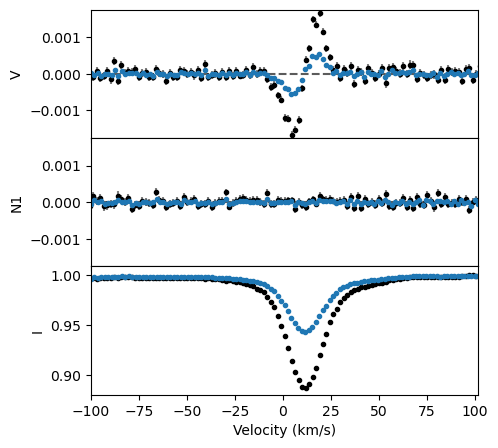

In [7]:
fig, ax = lsd.plot(figsize=(5,5))
fig, ax = lsd3.plot(fig=fig, sameYRange=False)

You can see that changing these parameters has a big impact on the amplitude of the LSD profile!  This does not, however, change the shape of the profile.  Changing the normalization parameters essentially causes the LSD profile to behave like a line with a different strength, wavelength, and Landé factor, hence the large change in amplitude of the profile.

Because these are such important parameters, they are included in the LSD object header. They will also be included in the header of the file when the LSD object is saved. 

In [8]:
print(lsd.header)
print(lsd3.header)

# normalizing: d=0.200 lande=1.200 wl= 500.0 (I norm weight 0.200, V norm weight 120.000)

# normalizing: d=0.100 lande=1.000 wl= 400.0 (I norm weight 0.100, V norm weight  40.000)



### 1.2 More advanced options

The LSDpy code and the <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy`</a> function have a set of more advanced options. For example:

* The default behavior is to remove lines in the mask that are very closely spaced. Lines that are less than one LSD pixel (i.e. `velPixel`) apart are treated.  Weaker lines are discarded and line depths are combined up to a maximum of 0.6. This can very roughly approximate a saturation effect, and it can be useful for lines that are very close due to fine or hyperfine structure. However, this may not be desirable for a carefully tuned line list. This option can be turned off by setting the keyword `trimMask` to `False`. 

* The default behavior is to remove continuum polarization from the Stokes V LSD profile. Even with this, large variations in the continuum polarization of the observation will still cause problems for the LSD calculation. This option can be turned off by setting the keyword `removeContPol` to `False`. 

* It is possible to perform a sigma clipping of the observed spectrum to reject bad pixels in the observation.  This is based on a comparison between the observed spectrum and the LSD model spectrum. This option is turned off by default, but can be controlled by the `sigmaClipIter` and the `sigmaClip` keywords. 

See the <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy`</a> API for more information. 

## 2. Having a look at the model spectrum

The `run_lsdpy` function also returns a <a href='../API/Spectrum_API.html#specpolFlow.Spectrum'>`Spectrum`</a> object that contains the LSD model (that is, the LSD profile convolved with the line mask -- or to be more precise, it is the LSD profile vector multiplied by the mask matrix). 

In the cell below, we overplot this model (purple) on the observed spectrum (grey). 

::::{margin}
:::{Note}
The <a href='../API/Mask_API.html#specpolFlow.cleanMaskUI'>`cleanMaskUI`</a> tool plots and use this model spectrum to assist in tweaking the line mask to better match the observed line depths. 
See [](3b-MaskUI_Tutorial.md).
:::
::::

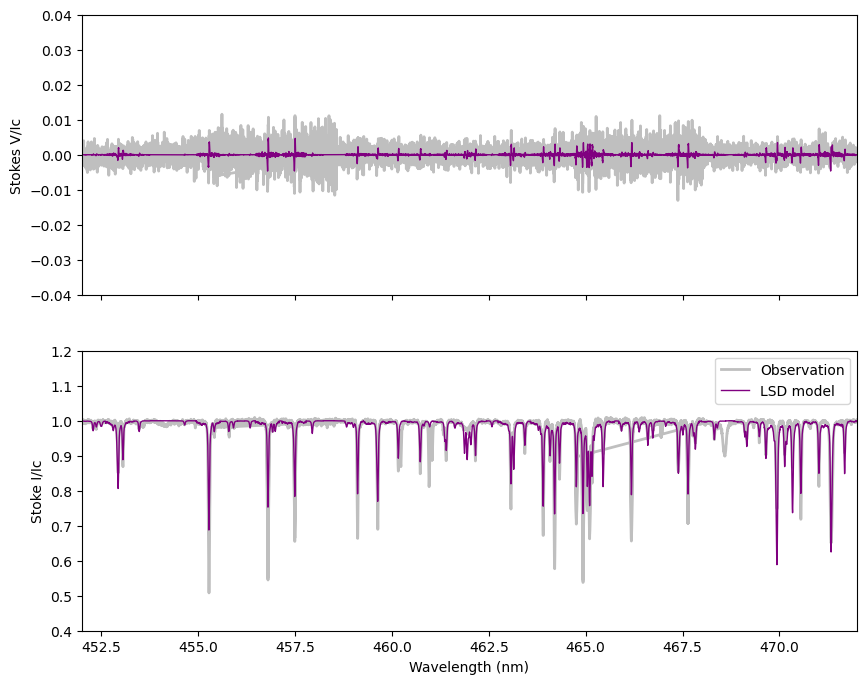

In [9]:
spec = pol.read_spectrum(obs_file)

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
ax[1].plot(spec.wl, spec.specI, lw=2, c='0.75', label='Observation')
ax[1].set_xlim(452.0, 472.0)
ax[1].set_ylim(0.4, 1.2)
ax[1].set_xlabel('Wavelength (nm)')
ax[1].set_ylabel('Stoke I/Ic')
ax[1].plot(mod.wl, mod.specI, c='purple', lw=1, label='LSD model')

ax[0].plot(spec.wl, spec.specV, lw=2, c='0.75')
ax[0].plot(mod.wl, mod.specV, c='purple', lw=1)
ax[0].set_ylim(-0.04, 0.04)
ax[0].set_ylabel('Stokes V/Ic')

ax[1].legend(loc=0)
plt.show()

You can see that most of the lines in the observation are reproduced by the model, but there are some discrepancies.  The overall fit to Stokes I is not perfect.  The fit to Stokes V is better, mostly because the amplitude of the lines is smaller relative to the noise in Stokes V.

In the text output from LSDpy:

In [10]:
lsd, mod = pol.run_lsdpy(obs=obs_file, mask=mask_file, 
                         velStart=-100.0, velEnd=100.0, velPixel=1.8,
                         normDepth=0.2, normLande=1.2, normWave=500.0,
                         plotLSD=False)

Modified line mask, removed 64 too closely spaced lines
Average observed spec velocity spacing: 1.810029 km/s
using a 113 point profile with 1.800000 km/s pixels
mean mask depth 0.101386 wl 494.081 Lande 1.179956 (from 1039 lines)
mean mask norm weightI 0.506930 weightV 0.480710
saving model spectrum to  ...
I reduced chi2 219.5795 (chi2 16986666.81 constraints 77473 dof 113)
 Rescaling error bars by: 14.818214
V reduced chi2 1.1248 (chi2 87017.85 constraints 77473 dof 113)
 Rescaling error bars by: 1.060586
 removing profile continuum pol: -5.5482e-06 +/- 1.2293e-08 (avg err 1.1064e-04)
N1 reduced chi2 1.1032 (chi2 85345.64 constraints 77473 dof 113)
 Rescaling error bars by: 1.050346
 removing profile continuum pol: -3.2734e-06 +/- 1.2057e-08 (avg err 1.0958e-04)
line range estimate -19.000000000000128 47.59999999999977 km/s
V in line reduced chi^2 54.634469 (chi2 2021.475344) 
 detect prob 1.000000 (fap 0.000000e+00)
 Detection! V (fap 0.000000e+00)
 V outside line reduced chi^2 1.3

you will notice some information about the reduced $\chi^2$ between the model spectrum and the observed spectrum. 

The error bars in Stokes I and V LSD profiles are scaled up, by multiplying the formal error bar by the square root of the reduced $\chi^2$.  Thus LSD profiles that do a worse job fitting the observation will generally have larger error bars. This often leads to the Stokes I LSD profile having larger uncertainties than the Stokes V profile.

## 3. Saving results

In all of the examples above, we were interested in looking at the LSD profiles produced. We did not, however, save the resulting LSD profiles nor the LSD model spectra as files! 

:::{tip}
Saving files can be done at anytime with the associated class functions <a href='../API/LSD_API.html#specpolFlow.LSD.save'>`LSD.save`</a> and <a href='../API/Spectrum_API.html#specpolFlow.Spectrum.save'>`Spectrum.save`</a> functions. (This is useful when manipulating LSD profiles in your workflow.)
:::

Often we will be interested in saving the LSD profile, and perhaps the LSD model spectrum, as files straight away. The <a href='../API/LSD_API.html#specpolFlow.run_lsdpy'>`run_lsdpy`</a> function has some keywords to do just so during its call. 

In [11]:
lsd, mod = pol.run_lsdpy(obs=obs_file, mask=mask_file, 
                         outLSDName='Output/prof.lsd', 
                         outModelName='Output/model.s',
                         velStart=-100.0, velEnd=100.0, velPixel=1.8, 
                         plotLSD=False)

Modified line mask, removed 64 too closely spaced lines
Average observed spec velocity spacing: 1.810029 km/s
using a 113 point profile with 1.800000 km/s pixels
mean mask depth 0.101386 wl 494.081 Lande 1.179956 (from 1039 lines)
mean mask norm weightI 0.506930 weightV 0.480710
saving model spectrum to Output/model.s ...
I reduced chi2 219.5795 (chi2 16986666.81 constraints 77473 dof 113)
 Rescaling error bars by: 14.818214
V reduced chi2 1.1248 (chi2 87017.85 constraints 77473 dof 113)
 Rescaling error bars by: 1.060586
 removing profile continuum pol: -5.5482e-06 +/- 1.2293e-08 (avg err 1.1064e-04)
N1 reduced chi2 1.1032 (chi2 85345.64 constraints 77473 dof 113)
 Rescaling error bars by: 1.050346
 removing profile continuum pol: -3.2734e-06 +/- 1.2057e-08 (avg err 1.0958e-04)
line range estimate -19.000000000000128 47.59999999999977 km/s
V in line reduced chi^2 54.634469 (chi2 2021.475344) 
 detect prob 1.000000 (fap 0.000000e+00)
 Detection! V (fap 0.000000e+00)
 V outside line red